In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import random
from torch.utils.data import Subset


100%|██████████| 9.91M/9.91M [00:00<00:00, 110MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 59.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 68.1MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.77MB/s]


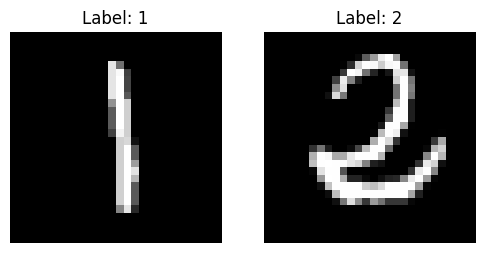

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# Randomly select 2000 indices
subset_indices = random.sample(range(len(mnist_dataset)), 2000)
mnist_dataset = Subset(mnist_dataset, subset_indices)

random_indices = random.sample(range(len(mnist_dataset)), 2)

image1, label1 = mnist_dataset[random_indices[0]]
image2, label2 = mnist_dataset[random_indices[1]]

def show_images(images, labels):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))
    for ax, img, lbl in zip(axes, images, labels):
        ax.imshow(img.squeeze(), cmap='gray')
        ax.set_title(f'Label: {lbl}')
        ax.axis('off')
    plt.show()

show_images([image1, image2], [label1, label2])

# Model From Scracth

We will implement the Convolutional Layer, Max Pooling, Linear Layer, and Softmax from scratch to explore the overall structure of each layer.

A neural network layer has two major components:
- **Forward Pass:** Passes its own output to the next layer.
- **Backward Propagation:** Adjusts the weights and biases based on the gradient and passes the processed values back to the previous layer.

Some layers, such as pooling layers and activation functions, may not require weight adjustments, but they still need to be part of the backward propagation to complete the full pipeline.

In [ ]:
class Conv:

    def __init__(self, num_filters):
        self.num_filters = num_filters

        #Xavier initialization
        #Kernel size in this case is locked to 3 x 3
        self.filters = np.random.randn(num_filters, 3, 3)/9

    def iterate_regions(self, image):
        if image.shape[0] == 1:
            image = image.squeeze(0)
        h,w = image.shape

        for i in range(h-2):
            for j in range(w-2):
                im_region = image[i:(i+3), j:(j+3)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input
        if input.shape[0] == 1:
            input = input.squeeze(0)
        h,w = input.shape

        output = np.zeros((h-2, w-2, self.num_filters))

        for im_regions, i, j in self.iterate_regions(input):
            output[i, j] = np.sum(im_regions * self.filters, axis=(1,2))
        return output

    def backprop(self, d_l_d_out, learn_rate):
        #Zeros all left over gradient
        d_l_d_filters = np.zeros(self.filters.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            for f in range(self.num_filters):
                d_l_d_filters[f] += d_l_d_out[i,j,f] * im_region

        #Update kernel
        self.filters -= learn_rate * d_l_d_filters

        return None

class MaxPool:
    def iterate_regions(self, image):
        h, w, _ = image.shape

        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield im_region, i, j

    def forward(self, input):

        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h//2, w//2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i,j] = np.amax(im_region,axis=(0,1))

        return output

    def backprop(self, d_l_d_out):
        #Zeros all left over gradient
        d_l_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            amax = np.amax(im_region, axis=(0,1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        #if the pixel was the max value, copy the gradient to it
                        if(im_region[i2,j2,f2] == amax[f2]):
                            d_l_d_input[i*2+i2, j*2+j2 ,f2] = d_l_d_out[i, j, f2]
                            break;
        return d_l_d_input





class LinearAndSoftmax:
    def __init__(self, input_len, nodes):
        self.weights = np.random.randn(input_len, nodes)/input_len
        self.biases = np.zeros(nodes)

    def forward(self, input):

        self.last_input_shape = input.shape

        input = input.flatten()
        self.last_input = input

        input_len, nodes = self.weights.shape

        totals = np.dot(input, self.weights) + self.biases
        self.last_totals = totals

        exp = np.exp(totals)
        return(exp/np.sum(exp, axis=0))

    def backprop(self, d_l_d_out, learn_rate):
        for i, gradient in enumerate(d_l_d_out):
            if(gradient == 0):
                continue

            t_exp = np.exp(self.last_totals)
            S = np.sum(t_exp)
            d_out_d_t = -t_exp[i] * t_exp/ (S**2)
            d_out_d_t[i] = t_exp[i] * (S-t_exp[i]) /(S**2)

            d_t_d_w = self.last_input
            d_t_d_b = 1
            d_t_d_inputs = self.weights

            d_l_d_t = gradient * d_out_d_t

            d_l_d_w = d_t_d_w[np.newaxis].T @ d_l_d_t[np.newaxis]
            d_l_d_b = d_l_d_t * d_t_d_b
            d_l_d_inputs = d_t_d_inputs @ d_l_d_t

            self.weights -= learn_rate * d_l_d_w
            self.biases -= learn_rate * d_l_d_b
            return d_l_d_inputs.reshape(self.last_input_shape)

## Model initialization

In [ ]:
conv = Conv(8) # 8 Filter Kernel locked at 3 x 3 size
pool = MaxPool()
liner_softmax = LinearAndSoftmax(13 * 13 * 8, 10)

## Training Loop

The training loop consists of the forward pass and backward propagation. We can also print the loss and accuracy to monitor the model's progress.

In [ ]:
# Forward Pass
def forward(image, label):

    out = conv.forward((image/255) - 0.5)
    out = pool.forward(out)
    out = liner_softmax.forward(out)

    loss = -np.log(out[label])
    acc = 1 if(np.argmax(out) == label) else 0

    return out, loss, acc


def train(im, label, lr=0.001):
    out,loss,acc = forward(im, label)

    # Backward Propagation
    gradient = np.zeros(10)
    gradient[label] = -1/out[label]
    gradient = liner_softmax.backprop(gradient, lr)
    gradient = pool.backprop(gradient)
    gradient = conv.backprop(gradient, lr)

    return loss, acc


# 3 Epoch of training
for epoch in range(3):
    print('----EPOCH %d ---'%(epoch+1))
    loss = 0
    num_correct = 0
    num_total = 0

    for i, (im, label) in enumerate(mnist_dataset):
        if(i>0 and i %100 == 99):
            print('[Step %d] Past 100 steps: Average Loss %.3f | Accuracy: %d%%' %(i + 1, loss / 100, (num_correct / num_total) * 100))

            loss = 0

        im = im.numpy()
        l, acc = train(im, label)
        loss += l
        num_correct += acc
        num_total += 1

----EPOCH 1 ---
[Step 100] Past 100 steps: Average Loss 2.279 | Accuracy: 12%
[Step 200] Past 100 steps: Average Loss 2.304 | Accuracy: 10%
[Step 300] Past 100 steps: Average Loss 2.324 | Accuracy: 10%
[Step 400] Past 100 steps: Average Loss 2.318 | Accuracy: 9%
[Step 500] Past 100 steps: Average Loss 2.297 | Accuracy: 11%
[Step 600] Past 100 steps: Average Loss 2.330 | Accuracy: 10%
[Step 700] Past 100 steps: Average Loss 2.313 | Accuracy: 10%
[Step 800] Past 100 steps: Average Loss 2.310 | Accuracy: 10%
[Step 900] Past 100 steps: Average Loss 2.324 | Accuracy: 9%
[Step 1000] Past 100 steps: Average Loss 2.290 | Accuracy: 9%
[Step 1100] Past 100 steps: Average Loss 2.307 | Accuracy: 9%
[Step 1200] Past 100 steps: Average Loss 2.336 | Accuracy: 9%
[Step 1300] Past 100 steps: Average Loss 2.305 | Accuracy: 9%
[Step 1400] Past 100 steps: Average Loss 2.321 | Accuracy: 9%
[Step 1500] Past 100 steps: Average Loss 2.295 | Accuracy: 9%
[Step 1600] Past 100 steps: Average Loss 2.283 | Accurac

# Model with Pytorch

We can also use the PyTorch library to build neural network models with various configurations. PyTorch provides built-in modules for convolutional layers, pooling layers, activation functions, and fully connected layers, allowing us to define complex models efficiently.

In [ ]:
# @title CNNs model
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time

torch.manual_seed(42)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=4, stride=2, padding=1)  # 1x28x28 ---> 10x14x14
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 10x14x14 ---> 10x7x7
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, stride=1, padding=0) # 10x7x7 ---> 20x5x5
        self.fc1 = nn.Linear(20 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 20 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model init
model = CNN()

We can also use the summary function to analyze the resources required by our model, including the number of parameters in each layer. This helps us understand the model’s complexity and memory usage, making it easier to optimize.

In [ ]:
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 14, 14]             170
         MaxPool2d-2             [-1, 10, 7, 7]               0
            Conv2d-3             [-1, 20, 5, 5]           1,820
            Linear-4                  [-1, 128]          64,128
            Linear-5                   [-1, 32]           4,128
            Linear-6                   [-1, 10]             330
Total params: 70,576
Trainable params: 70,576
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.27
Estimated Total Size (MB): 0.30
----------------------------------------------------------------


Now we can configure hyperparameters such as the loss function, number of epochs, learning rate, and optimizer.

In [ ]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

epoch_number = 0

# Number of epoch for training
EPOCHS = 10

# Variable for logging training history
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

Now we split the dataset into two parts: one for training and one for testing. The training set is used to teach the model, while the testing set evaluates its performance on unseen data.

In [ ]:
from torch.utils.data import random_split, DataLoader
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_dataset))
test_size = len(mnist_dataset) - train_size

# Perform split
train_dataset, test_dataset = random_split(mnist_dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
t_0 = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Zeros all left over gradient
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and Perform Backward Propagation
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(train_loader))
    training_logs["train_acc"].append(train_correct / len(train_loader.dataset))

    running_vloss = 0.0
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        training_logs["validate_loss"].append(valid_loss / len(test_loader))
        training_logs["validate_acc"].append(valid_correct / len(test_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    if valid_loss < best_vloss:
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end = time.time()-t_0
print(f"Time consumption for training: {t_end} sec")

Epochs 1   train loss 2.29760 train acc 0.10279 validate loss 2.28146 validate acc 0.13725
--------------------------------------------------------------------------------
Epochs 2   train loss 1.94824 train acc 0.46081 validate loss 0.88916 validate acc 0.74142
--------------------------------------------------------------------------------
Epochs 3   train loss 0.58049 train acc 0.81835 validate loss 0.47359 validate acc 0.85100
--------------------------------------------------------------------------------
Epochs 4   train loss 0.41221 train acc 0.87183 validate loss 0.38970 validate acc 0.88075
--------------------------------------------------------------------------------
Epochs 5   train loss 0.33807 train acc 0.89523 validate loss 0.33362 validate acc 0.89392
--------------------------------------------------------------------------------
Epochs 6   train loss 0.28465 train acc 0.91121 validate loss 0.27416 validate acc 0.91350
-------------------------------------------------

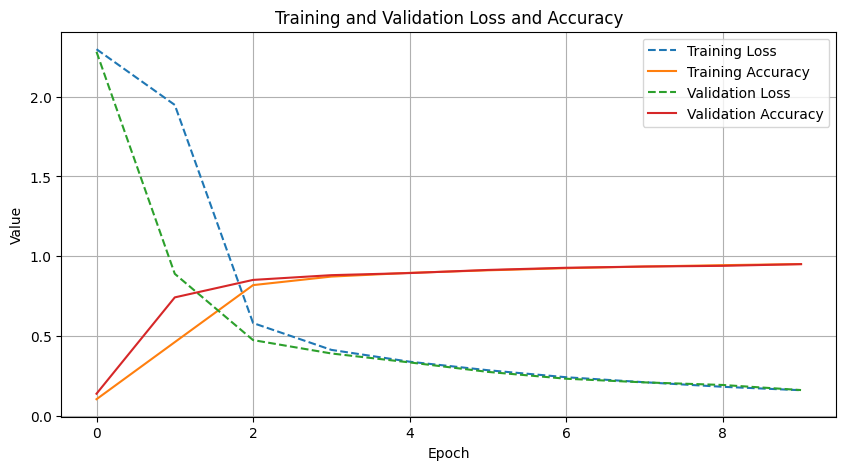

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(training_logs["train_loss"], linestyle='--', label='Training Loss')
plt.plot(training_logs["train_acc"], label='Training Accuracy')
plt.plot(training_logs["validate_loss"], linestyle='--', label='Validation Loss')
plt.plot(training_logs["validate_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# @title Vanilla ANNs model function (784-128-32-10 layer nodes)
torch.manual_seed(42)

class ANN(nn.Module):
    def __init__(self):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model Initialization
model = ANN()
summary(model, (1, 28, 28))
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
            Linear-2                   [-1, 32]           4,128
            Linear-3                   [-1, 10]             330
Total params: 104,938
Trainable params: 104,938
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.40
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


Epochs 1   train loss 2.01772 train acc 0.41863 validate loss 1.35410 validate acc 0.63892
--------------------------------------------------------------------------------
Epochs 2   train loss 0.83308 train acc 0.78346 validate loss 0.58359 validate acc 0.84908
--------------------------------------------------------------------------------
Epochs 3   train loss 0.47661 train acc 0.87069 validate loss 0.42562 validate acc 0.88442
--------------------------------------------------------------------------------
Epochs 4   train loss 0.38125 train acc 0.89415 validate loss 0.37703 validate acc 0.89617
--------------------------------------------------------------------------------
Epochs 5   train loss 0.34193 train acc 0.90271 validate loss 0.34584 validate acc 0.90325
--------------------------------------------------------------------------------
Epochs 6   train loss 0.31734 train acc 0.91052 validate loss 0.32560 validate acc 0.90667
-------------------------------------------------

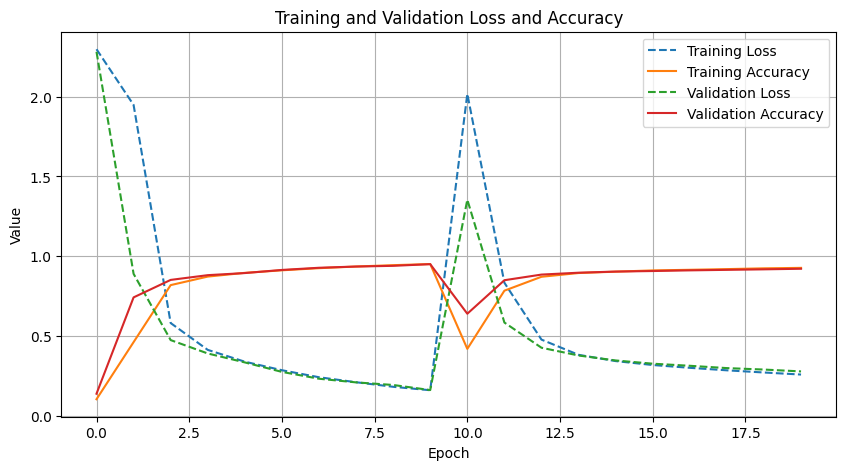

In [ ]:
t_0 = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    model.train(True)
    for i, data in enumerate(train_loader):
        inputs, labels = data

        # Zeros all left over gradient
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and Perform Backward Propagation
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(train_loader))
    training_logs["train_acc"].append(train_correct / len(train_loader.dataset))

    running_vloss = 0.0
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(test_loader):
            vinputs, vlabels = vdata
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        training_logs["validate_loss"].append(valid_loss / len(test_loader))
        training_logs["validate_acc"].append(valid_correct / len(test_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    if valid_loss < best_vloss:
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_model.pth')

    epoch_number += 1

t_end = time.time()-t_0
print(f"Time consumption for training: {t_end} sec")

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(training_logs["train_loss"], linestyle='--', label='Training Loss')
plt.plot(training_logs["train_acc"], label='Training Accuracy')
plt.plot(training_logs["validate_loss"], linestyle='--', label='Validation Loss')
plt.plot(training_logs["validate_acc"], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training and Validation Loss and Accuracy')
plt.legend()
plt.grid(True)
plt.show()